# Diverging Chart creation

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# to use regular expressions
import re
import matplotlib.colors as mcolors

In [37]:
# Set font
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]

In [38]:
# Load dataset
df = pd.read_csv('/kaggle/input/book-reading-in-greece-vs-age/Reshaped_Book_Reading_Data.csv')

In [39]:
df.head()

,Age Group,Sex,Book Category,Percentage
0,From 16 to 24 years,Male,No Books,51.0
1,From 25 to 34 years,Male,No Books,57.6
2,From 35 to 44 years,Male,No Books,64.0
3,From 45 to 54 years,Male,No Books,65.5
4,From 55 to 64 years,Male,No Books,65.0


### Data preprocessing

In [40]:
# Pivot table
df_pivot = df.pivot_table(
    # Each row in the resulting pivot table will represent a unique combination of Age Group and Book Category
    index=["Age Group", "Book Category"],
    #  split the values by sex
    columns="Sex",
    # Column to aggregate
    values="Percentage",
    # Value to replace missing values with
    fill_value=0
).reset_index()


# Sort age groups
def sort_age_group(age):
    # Search for the decimals in the age groups
    match = re.search(r'\d+', age)
    # group() returns the string matched by the RE and int() extracts it
    return int(match.group()) if match else 0

# Create a column with the extracted numbers from the strings
df_pivot["Age Sort"] = df_pivot["Age Group"].apply(sort_age_group)
# Sort the table according to these numbers
df_pivot = df_pivot.sort_values("Age Sort", ascending=False)

# return an array of the available age groups
age_groups = df_pivot["Age Group"].unique()
# return an array of the available categories
categories = df_pivot["Book Category"].unique()

# Reverse categories to match fading from No Books → 10+ books
categories = categories[::-1]

In [41]:
df_pivot.head()

Sex,Age Group,Book Category,Female,Male,Age Sort
0,65 years or over,10+,3.5,3.4,65
1,65 years or over,5 to 9,5.6,4.9,65
2,65 years or over,Less than 5,21.7,20.6,65
3,65 years or over,No Books,69.2,71.0,65
22,From 55 to 64 years,Less than 5,37.7,24.0,55


### Color palettes definitions

In [42]:
# Custom gradient for male
# Hex colors are strings and can't be used for mathematical operations like interpolation, so mcolors converts them to a tuple
green = mcolors.to_rgb("#566b45")
green_grey = mcolors.to_rgb("#CCD2C7")
# Custom gradient for female
purple = mcolors.to_rgb("#6b4565")
purple_grey = mcolors.to_rgb("#d2c7d0")
grey = mcolors.to_rgb("#d6eac5")

# create a list for the male color gradient, with 4 colors
male_colors = [
    # convert back to hex once the below operation has been carried out
    mcolors.to_hex([
        # calculate the in-between colors
        green[i] + (green_grey[i] - green[i]) * (idx / (len(categories) - 1))
        for i in range(3)
    ])
    for idx in range(len(categories))
]

# create a list for the female color gradient, with 4 colors
female_colors = [
    mcolors.to_hex([
        purple[i] + (purple_grey[i] - purple[i]) * (idx / (len(categories) - 1))
        for i in range(3)
    ])
    for idx in range(len(categories))
]

In [43]:
# Create empty arrays to store male and female data
male_data = []
female_data = []

for cat in categories:
    # give the male values a negative value, in order to create the diverging chart
    male_data.append(-df_pivot[df_pivot["Book Category"] == cat]["Male"].values)
    female_data.append(df_pivot[df_pivot["Book Category"] == cat]["Female"].values)

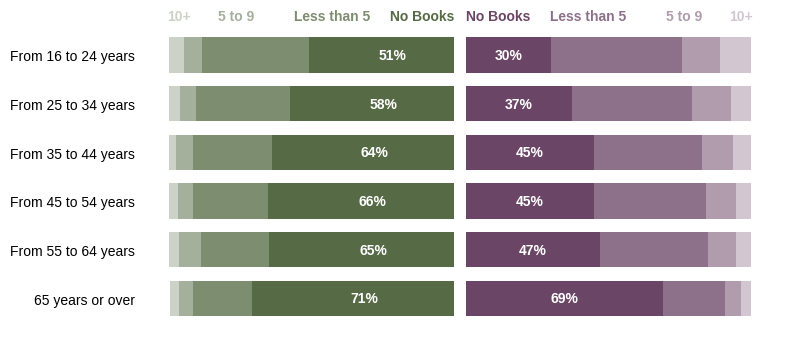

In [49]:
# Plot
fig, ax = plt.subplots(figsize=(8, 3.5))
# indexes of the age groups
y_pos = np.arange(len(age_groups))

# spacing that I'll use in the charts
gap = 1.99
bar_height = 0.725  

# Create stacked horizontal bars for men
# left will be an array filled with full() with the number of age groups (len) and the spacing defined earlier
left = np.full(len(age_groups), -gap)
for i, cat_data in enumerate(male_data):
    # create the bars, iterate over the palette we created earlier
    # the left side of the bars will take the values for each Book reading frequency value, 
    # the one adding to the previous one, creating the stacked effect
    ax.barh(y_pos, cat_data, left=left, height=bar_height, color=male_colors[i], edgecolor='none')
    left += cat_data

# Create stacked horizontal bars for women, similar to before
right = np.full(len(age_groups), gap)
for i, cat_data in enumerate(female_data):
    ax.barh(y_pos, cat_data, left=right, height=bar_height, color=female_colors[i], label=categories[i], edgecolor='none')
    right += cat_data

# Add labels for 'No Books' category (both male and female), so it stands out
no_books_index = list(categories).index("No Books")

# Labels for male
# If the Book Category is 'No Books', grab the value for Male
male_vals = df_pivot[df_pivot["Book Category"] == "No Books"]["Male"].values
x_pos_male = np.full(len(age_groups), -gap)
for i, val in enumerate(male_vals):
    # Give the text position negative values, so it's displayed on the left of y=0 (i.e. create the diverging effect)
    # Place it in the moddle (val/2)
    ax.text(-x_pos_male[i] - val / 2, y_pos[i], f"{abs(val):.0f}%", 
            va='center', ha='center', color='white', fontsize=10, fontweight='bold')

# Labels for female
female_vals = df_pivot[df_pivot["Book Category"] == "No Books"]["Female"].values
x_pos_female = np.full(len(age_groups), gap)
for i, val in enumerate(female_vals):
    ax.text(x_pos_female[i] + val / 2, y_pos[i], f"{val:.0f}%", 
            va='center', ha='center', color='white', fontsize=10, fontweight='bold')

# Aesthetics
# pass on the list of y positions of y ticks
ax.set_yticks(y_pos)
# use the age_group names as labels
ax.set_yticklabels(age_groups, fontsize=10) 
# Hide tick marks
ax.tick_params(axis='y', length=0)  

# no x ticks & labels
ax.set_xticks([])
ax.set_xlabel("")

# Horizontal layout for category labels
label_y = len(age_groups) - 0.2  

# Add male side labels (right to left)
# start at the left side of the chart
x = - gap 
for i, cat in enumerate(categories):
    ax.text(x, label_y, cat, color=male_colors[i],
            ha='right', va='center', fontsize=10, fontweight='bold')
    x -= len(cat)*3.7 
    
# Add female side labels (left to right)
x = gap  # start at the right side of the chart
for i, cat in enumerate(categories):
    ax.text(x, label_y, cat, color=female_colors[i],
            ha='left', va='center', fontsize=10, fontweight='bold')
    x += len(cat)*3.7 

# Remove the borders of the plot
sns.despine(top=True, right=True, left=True, bottom=True)

# adjust the padding of the plot to make sure all elements fit within the figure boundaries
plt.tight_layout()
# Save to png for export
plt.savefig("book_reading_chart.png", dpi=300, bbox_inches='tight')

plt.show()